## QUESTION 1

Implement the template based chord recognition algorithm. Define a function that takes as input the
path to a wav file and returns the estimated chords sequence labels.
The output must be a list

\begin{equation}
\lambda^{pred} = [\lambda^{pred}_{0}, \lambda^{pred}_{1}, ...\lambda^{pred}_{N-1}] \ \ (1)\end{equation}

where each element $\lambda^{pred}_n$ is the predicted chord label for the time frame n. 
The length of the list depends on the feature rate, i.e., both on the window length and hop size 
used for the chromagram computation and on the downsampling factor, if feature downsampling is 
applied.

The chord templates to be considered are the major triads and the minor triads, leading to a total of 24 templates.
Once the function is defined in the notebook, test the function on the wav file *Beatles LetItBe.wav*,
available in */data/wav/* folder, and print or plot the output.

Explain in the report the idea behind the template-based chord recognition algorithm and detail each
step implemented in the code, including pre processing and post processing phases.

In [1]:
#Import all packages
import os, sys
import math
from math import modf
import sys
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
%matplotlib inline

#Generate the reference chords matrix
def generate_template_matrix(templates):
    template_matrix = np.zeros((12, 12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)
    return template_matrix

#Create the normalization of the matrix sent as input
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):   
    K, N = X.shape
    X_norm = np.zeros((K, N))
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v            
    if norm == 'max':
        if v is None:
            v = np.ones(K)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    return X_norm

#Create the smoothing and dowmsampling algorithm
def smooth_downsample_feature_sequence(X, Fs, filt_len, down_sampling, w_type='boxcar'):
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

#Create the template match algorithm
def analysis_template_match(chromagram, templates, smoothing_window_length, smoothing_down_sampling,
                            Fs, norm_chromagram='2', norm_output='2'):
    
    chroma_normalized = normalize_feature_sequence(chromagram, norm=norm_chromagram)
    if smoothing_window_length and smoothing_down_sampling:
        chroma_normalized, Fs_feat = smooth_downsample_feature_sequence(chroma_normalized, 
                                                                        down_sampling=smoothing_down_sampling,
                                                                        filt_len=smoothing_window_length, Fs=Fs)
    templates_normalized = normalize_feature_sequence(templates, norm=norm_chromagram)
    chord_similarity = np.matmul(templates_normalized.T, chroma_normalized)
    if norm_output:
         chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
    chord_max = (chord_similarity == chord_similarity.max(axis=0)).astype(int)
    return chord_similarity, chord_max

#Create a function which translates the matrix of chords(given by 0 and 1) in a list of chords of strings
def chordList(templates, template_sequence):
    
    template_sequence[template_sequence != 0] = 1 #maximise the values of the matrix of chords
    chords = []
    
    #Analize each sample of the audio matrix with the reference ones, when they are equal then give its proper chord name
    for i in range(template_sequence.shape[1]):
        for j in range(templates.shape[1]):
            if(np.array_equal(template_sequence[:,i], templates[:,j])): 
                #majorChords
                if(j==0):
                    chords.append("C")
                if(j==1):
                    chords.append("C#")
                if(j==2):
                    chords.append("D")
                if(j==3):
                    chords.append("D#")
                if(j==4):
                    chords.append("E")
                if(j==5):
                    chords.append("F")
                if(j==6):
                    chords.append("F#")
                if(j==7):
                    chords.append("G")
                if(j==8):
                    chords.append("G#")
                if(j==9):
                    chords.append("A")
                if(j==10):
                    chords.append("A#")   
                if(j==11):
                    chords.append("B")
                    
                #minorChords
                if(j==12):
                    chords.append("Cm")
                if(j==13):
                    chords.append("C#m")
                if(j==14):
                    chords.append("Dm")
                if(j==15):
                    chords.append("D#m")
                if(j==16):
                    chords.append("Em")
                if(j==17):
                    chords.append("Fm")
                if(j==18):
                    chords.append("F#m")
                if(j==19):
                    chords.append("Gm")
                if(j==20):
                    chords.append("G#m")
                if(j==21):
                    chords.append("Am")
                if(j==22):
                    chords.append("A#m")   
                if(j==23):
                    chords.append("Bm")
    return chords

#Main function
def template_based_chord_recognigtion(audioPath, L=None, D=None,  N = 22050, H = 22050):
    #Generate Chord Template Matrix
    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T
    templates = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))
  
    #Parameters
    Fs = 22050 
    
    if(N != Fs):
        N = N
    elif(N == Fs):
        N = Fs
        
    if(H != N):
        H = H
    elif(H == N):
        H = N

    #Read audio
    x, Fs = librosa.load(audioPath, sr=Fs)
    
    #STFT
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
    X = np.abs(X) ** 2
    
    #logarithmic compression
    gamma = 0.1
    X = np.log(1 + gamma * np.abs(X) ** 2)
    
    #Chromagram
    C = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, hop_length=H, n_fft=N, norm=None)
    
    #Analize chords
    chords_sim, chords_max = analysis_template_match(C, templates, 
                                                smoothing_window_length=L,
                                                smoothing_down_sampling=D, 
                                                Fs=Fs,
                                                norm_chromagram = '2', 
                                                norm_output = 'max')
    
    # Compute normalized binary templates of analysis
    templates_normalized = normalize_feature_sequence(templates, norm = '2')
    template_sequence = np.matmul(templates_normalized, chords_max)
    
    #Create the list of chords
    chords = chordList(templates, template_sequence)
    return chords, template_sequence, templates, Fs, N, H

audioWav = os.path.join('data','wav', 'Beatles_LetItBe.wav')
chords_WAV, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(audioWav)
print('Audio: ' '\033[1m' + 'Beatles_LetItBe.wav' + '\033[0m')
print('List of predicted chords: ' + str(len(chords_WAV))+ ' elements.\n')
print(chords_WAV)

Audio: Beatles_LetItBe.wav
List of predicted chords: 243 elements.

['C', 'C', 'G', 'G', 'Am', 'C', 'F', 'C', 'C', 'G', 'F', 'Em', 'C', 'C', 'C', 'G', 'G', 'C#m', 'Dm', 'F', 'Em', 'E', 'G', 'Dm', 'C', 'C', 'C', 'C', 'G', 'D', 'D', 'D', 'Dm', 'Em', 'E', 'G', 'Bm', 'C', 'Em', 'C', 'Em', 'Em', 'A#', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Dm', 'F', 'C', 'C', 'Am', 'Gm', 'Dm', 'E', 'C#', 'Dm', 'E', 'E', 'G', 'Dm', 'Dm', 'C', 'C', 'C', 'Gm', 'D', 'E', 'G', 'Dm', 'E', 'E', 'G', 'Bm', 'C', 'C', 'Gm', 'Am', 'C', 'Em', 'C', 'Am', 'Cm', 'C', 'Em', 'Em', 'G', 'Dm', 'A#', 'Em', 'Am', 'G', 'G', 'G', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Bm', 'C', 'C', 'Am', 'G', 'C', 'Dm', 'G', 'Dm', 'Gm', 'F', 'F', 'C', 'F', 'G', 'F', 'A#', 'Am', 'C', 'G', 'G', 'D#', 'Gm', 'C', 'C', 'Am', 'D#', 'Gm', 'A', 'G', 'Gm', 'C', 'Gm', 'G', 'G', 'A', 'Gm', 'E', 'C', 'C', 'Am', 'Em', 'G', 'C', 'Am', 'Am', 'C', 'G', 'Bm', 'Am', 'A', 'C', 'Em', 'C', 'G', 'Bm', 'Dm', 'F', 'C', 'G', 'Em', 'G', 'D', 'E', 'D', 'D', 'Em', 'C', 'Gm', 'Bm', '

## QUESTION 2

Write a function to load and preprocess a reference annotation (or ground truth) file, saved in CSV
format. The function should take as input the path to a CSV file and produce as output a list of ground
truth chord labels, after suitable pre processing. The output must be a list

\begin{equation}
\lambda^{gt} = [\lambda^{gt}{0}, \lambda^{gt}{0}, ...\lambda^{gt}_{N-1}] \ \ (2)\end{equation} 

where each element $\lambda^{gt}_n$ is the ground truth chord label for the time window $n$. 
The length of the list must be adapted to match the the feature rate.

The reference annotations stored in the CSV file are given in the form of labelled segments, each
specified as a triplet (start, end, $\lambda$) where start and end are expressed in seconds. To load the CSV file
check the *csv* library (distributed with Python) or *Pandas* library (needs to be installed).

In the preprocessing step you should
* convert the segment-based annotation into a frame-based label sequence adapted to the feature rate
used for the chroma sequence;
* convert the labels used in the annotation file to match the chord labels used for the chord recognition
algorithm in terms of enharmonic equivalence (i.e., *Db = C#* );

* reduce the chord label set used in the annotation to match the chord labels set used for the chord
recognition algorithm (i.e., *DMaj6 → D*); for this step you can choose any reduction strategy.

Once the function is defined in the notebook, test the function on the CSV file *Beatles LetItBe.csv*,
available in */data/csv/* folder, and print or plot the output.
Explain in the report each step of the preprocessing phase, focusing in particular on the reduction
strategy of the chord label set.

In [2]:
#Read the CSV file from a path and return the list of chords of the csv adapted to length of the same list of the audio.
def chordsFromCsv(path):
    import csv
    with open(path) as csv_file:
        
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        chords = [] #chords of csv
        i = 0;
        note = ['C','D','E','F','G','A','B']
        
        delta_t_wav =  H / Fs #time interval of each frame of the audio
        delta_t_csv = [] #time interval of each chords in seconds of the csv    
        chordsCSV_adapted = [] #list of the chords of csv adapted to the length of the list of the chords of the audio       
        nRep_chord = [] #number of repetitions of each chord of the csv
        
        for row in csv_reader:
            
            if line_count == 0:
                line_count += 1
            else:
                delta_t_csv.append(row[1])#extract the time interval of the chord
                if "min" in row[2].split(':'):
                    temp = row[2].split(':')[0]+'m' #change min in m
                else:
                    temp = row[2].split(':')[0] #extract the chord
                chords.append(temp.split('/')[0]) #do the proper cut and add to the list

        for e in chords:
            if 'b' in e:
                chords[i]=note[note.index(chords[i][0])-1]+'#' #change 'b' into '#'
            i += 1   
        
       #For each time interval extract the number of repetitions of each chord in csv list.
        frame = 0 #counter of the frames
        
        for i in range(len(delta_t_csv)):
            nRep_float = (float(delta_t_csv[i]) / delta_t_wav) - frame #extract number of repetitions in a frame of the audio
            nRep_chord.append(int(math.ceil(nRep_float))) #always round for excess
            frame = (frame + nRep_chord[i]) #increment the frame
            
        for i in range(len(chords)):
            for j in range(nRep_chord[i]):    
                chordsCSV_adapted.append(chords[i]) #insert in the list the chord for its number of repetitions
        
        #Adapt the length of two lists by removing the last element from the longest one        
        if (len(chordsCSV_adapted) != len(chords_WAV)): 
            diff = np.abs(len(chordsCSV_adapted) - len(chords_WAV))
            for i in range(diff):
                if(len(chordsCSV_adapted) > len(chords_WAV)):
                    chordsCSV_adapted.pop() 
                elif (len(chords_WAV) > len(chordsCSV_adapted)):
                    chords_WAV.pop()
            
    return chordsCSV_adapted

audioCSV = os.path.join('data','csv', 'Beatles_LetItBe.csv') 
chords_CSV = chordsFromCsv(audioCSV);
print('CSV: ' '\033[1m' + 'Beatles_LetItBe.csv' + '\033[0m')
print('List of chords of the CSV file: ' + str(len(chords_CSV))+ ' elements.\n')
print(chords_CSV)           


CSV: Beatles_LetItBe.csv
List of chords of the CSV file: 243 elements.

['C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'C', 'C', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'Am', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F',

## QUESTION 3

Propose a metric for evaluating the template based chord recognition algorithm. 
A metric

\begin{equation}
m = f(\lambda^{pred}, \lambda^{gt}) \ \ (3) \end{equation}

is a scalar number that expresses how good is the algorithm in performing the task of chord recognition.
The proposed metric should have higher values when the chord recognition algorithm is able to predict
correctly the ground truth chords most of the times, lower values if the chord recognition algorithm often
fails at recognising the chords.

Write a function that takes as input the list of predicted chord labels, the list of ground truth chord
labels and computes the proposed metric value. The two input lists must have same length and the
output must be a scalar value.

Once the function is defined in the notebook, test the function on the two lists of predicted and ground
truth chord labels computed in Question 1 and Question 2.

In the report write a formal definition of the proposed metric and thoroughly explain the idea behind
the proposal. Can you imagine a musically informed strategy that weights differently mismatch errors of
the chord recognition algorithm?

In [3]:
#Function which converts the list of chords of the csv into the correspondent binary matrix
def csv_notes(chordsCSV, templates):
    chordsCSV_notes = np.zeros((12, len(chordsCSV)))
    
    #Converts the CSV chords into binary triads from a reference template.
    for i in range(len(chordsCSV)):
        for j in range(templates.shape[1]):    
            #majorChords
            if(chordsCSV[i] == 'C'):
                chordsCSV_notes[:, i] = templates[:,0]
                    
            if(chordsCSV[i] == 'C#'):
                chordsCSV_notes[:, i] = templates[:,1]
                    
            if(chordsCSV[i] == 'D'):
                chordsCSV_notes[:, i] = templates[:,2]
                    
            if(chordsCSV[i] == 'D#'):
                chordsCSV_notes[:, i] = templates[:,3]
                    
            if(chordsCSV[i] == 'E'):
                chordsCSV_notes[:, i] = templates[:,4]
                    
            if(chordsCSV[i] == 'F'):
                chordsCSV_notes[:, i] = templates[:,5]
                    
            if(chordsCSV[i] == 'F#'):
                chordsCSV_notes[:, i] = templates[:,6]
                    
            if(chordsCSV[i] == 'G'):
                chordsCSV_notes[:, i] = templates[:,7]
                    
            if(chordsCSV[i] == 'G#'):
                chordsCSV_notes[:, i] = templates[:,8]
                    
            if(chordsCSV[i] == 'A'):
                chordsCSV_notes[:, i] = templates[:,9]
                    
            if(chordsCSV[i] == 'A#'):
                chordsCSV_notes[:, i] = templates[:,10]
                    
            if(chordsCSV[i] == 'B'):
                chordsCSV_notes[:, i] = templates[:,11]
                
            #minorChords
            if(chordsCSV[i] == 'Cm'):
                chordsCSV_notes[:, i] = templates[:,12]
                    
            if(chordsCSV[i] == 'C#m'):
                chordsCSV_notes[:, i] = templates[:,13]
                    
            if(chordsCSV[i] == 'Dm'):
                chordsCSV_notes[:, i] = templates[:,14]
                    
            if(chordsCSV[i] == 'D#m'):
                chordsCSV_notes[:, i] = templates[:,15]
                    
            if(chordsCSV[i] == 'Em'):
                chordsCSV_notes[:, i] = templates[:,16]
                    
            if(chordsCSV[i] == 'Fm'):
                chordsCSV_notes[:, i] = templates[:,17]
                    
            if(chordsCSV[i] == 'F#m'):
                chordsCSV_notes[:, i] = templates[:,18]
                    
            if(chordsCSV[i] == 'Gm'):
                chordsCSV_notes[:, i] = templates[:,19]
                    
            if(chordsCSV[i] == 'G#m'):
                chordsCSV_notes[:, i] = templates[:,20]
                    
            if(chordsCSV[i] == 'Am'):
                chordsCSV_notes[:, i] = templates[:,21]
                    
            if(chordsCSV[i] == 'A#m'):
                chordsCSV_notes[:, i] = templates[:,22]
                    
            if(chordsCSV[i] == 'Bm'):
                chordsCSV_notes[:, i] = templates[:,23] 

    return chordsCSV_notes

#Metric function                        
def metric(wav, csv):
    
    chordsCSV_notes = csv_notes(csv, templates) #convert the list into a binary matrix
    error = [] #list of errors
    for i in range(chordsCSV_notes.shape[1]):
        nNotesInCommon = 0 #Count the numbers of notes in common in the SAME position
        for j in range(chordsCSV_notes.shape[0]):
            if(chordsCSV_notes[j,i] == 1 and chordsCSV_notes[j,i] == wav[j,i]):
                nNotesInCommon += 1              
        
        #Define the grade of errors (0,1,2,3)
        if(nNotesInCommon == 3):
            error.append(0)
        if(nNotesInCommon == 2):
            error.append(1)
        if(nNotesInCommon == 1):
            error.append(2)
        if(nNotesInCommon == 0):
            error.append(3)
    
    m = 100 - (100*(np.sum(error)/(3*len(error)))) #calculate metric, where 3 is the max grade of error.
    m_round = round(m,2)
    return m_round

#Execute function
wav = template_sequence
m = metric(wav, chords_CSV)
print('Song:''\033[1m' + ' Beatles - Let It Be.' + '\033[0m')
print('Percentage of similarity between the previous lists: ''\033[1m'+ str(m)+ '%'+ '\033[0m')

Song: Beatles - Let It Be.
Percentage of similarity between the previous lists: 62.55%


## QUESTION 4

Compute the proposed metric for the remaining 3 songs:
* audio *Beatles HereComesTheSun.wav*, *CSV Beatles HereComesTheSun.csv*
* audio *Beatles PennyLane.wav*, *CSV Beatles PennyLane.csv*
* audio *Beatles ObLaDiObLaDa.wav*, *CSV Beatles ObLaDiObLaDa.csv*
all contained in folders */data/wav/* and */data/csv/*. 
Print or plot the metric values.

In [9]:
#Here comes the sun
chords_WAV, wav1, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'))
csv1 = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
m1 = metric(wav1, csv1)
print('Song:' '\033[1m' + ' Beatles - Here Comes The Sun' + '\033[0m' + ' / Percentage of similarity between the two lists: ''\033[1m'+ str(m1)+ '%'+ '\033[0m')

#PennyLane
chords_WAV, wav2, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'))
csv2 = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
m2 = metric(wav2, csv2)
print('Song:' '\033[1m' + ' Beatles - Penny Lane' + '\033[0m' + ' / Percentage of similarity between the two lists: ''\033[1m'+ str(m2)+ '%'+ '\033[0m')

#ObLaDiObLaDa
chords_WAV, wav3, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'))
csv3 = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
m3 = metric(wav3, csv3)
print('Song:' '\033[1m' + ' Beatles - ObLaDi ObLaDa' + '\033[0m' + ' / Percentage of similarity between the two lists: ''\033[1m'+ str(m3)+ '%'+ '\033[0m')


Song: Beatles - Here Comes The Sun / Percentage of similarity between the two lists: 50.27%
Song: Beatles - Penny Lane / Percentage of similarity between the two lists: 61.67%
Song: Beatles - ObLaDi ObLaDa / Percentage of similarity between the two lists: 47.97%


## QUESTION 5

Analyse how algorithm parameters affect the performance of the templated based chord recognition
algorithm.
Given one algorithm parameter (i.e., smoothing filter length $L$), choose a range of 3 possible values
for it (i.e.,$L = [0, 10, 20]$ ). 
For each value of the parameter, compute the predicted labels and the correspondent metric value for each song.
This produces a list of 3 metric values for each song.

Plot the results for all songs in a figure where the x-axis corresponds to the parameter values, the
y-axis corresponds to metric values. An example of the plot is in Figure 1.

Repeat this for at least 3 different algorithm parameters. 
Note that in every experiment you need to change only one parameter value at a time, while the others must be fixed.

Show the 3 plots both in the Jupyter Notebook and in the report. 
What considerations can you do from the 3 plots that you have? 
Are some algorithm parameters affecting the results more than others?
Comment the results in the report.

METRIC - SMOOTH LENGTH CHANGE
Smoothing window lengths: [0, 10, 20]

Beatles_LetItBe: ['62.55%', '52.87%', '58.2%']
Beatles_HereComesTheSun: ['50.27%', '41.94%', '46.06%']
Beatles_PennyLane: ['61.67%', '56.34%', '51.27%']
Beatles_ObLaDiObLaDa: ['47.97%', '55.2%', '59.26%']


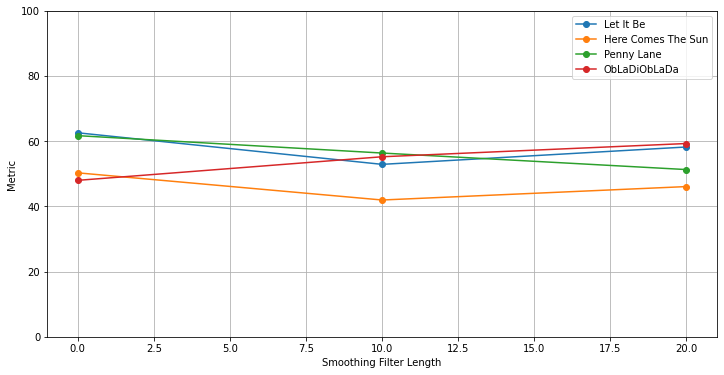

Metrics_DownsamplingChange
Beatles_LetItBe [57.92, 53.01, 61.79]
Beatles_HereComesTheSun [49.46, 51.77, 60.22]
Beatles_PennyLane [39.49, 38.41, 47.31]
Beatles_ObLaDiObLaDa [56.14, 58.33, 61.46]


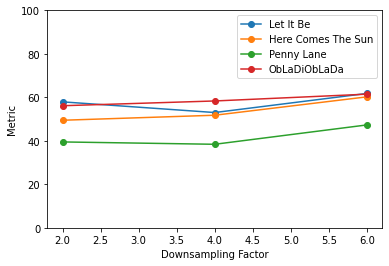

Metrics_N_Change
Beatles_LetItBe [62.55, 58.02, 55.01]
Beatles_HereComesTheSun [50.27, 47.21, 44.98]
Beatles_PennyLane [61.67, 62.06, 62.25]
Beatles_ObLaDiObLaDa [47.97, 49.38, 46.38]


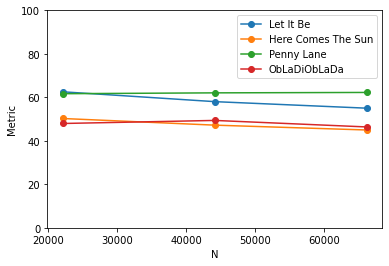

Metrics_HopsizeChange
Beatles_LetItBe [61.72, 62.44, 62.49]
Beatles_HereComesTheSun [50.72, 51.47, 51.44]
Beatles_PennyLane [62.13, 62.55, 62.91]
Beatles_ObLaDiObLaDa [50.79, 49.07, 49.77]


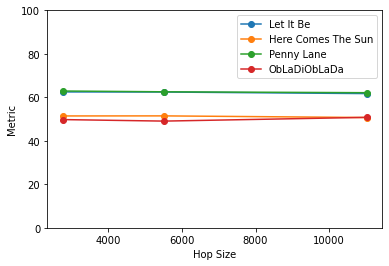

In [15]:
'''
def smoothChange(audioPath, csvPath, L, D):
    metricsStr = []
    metricsFloats = []
    for i in range(len(L)):
        chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(audioPath, L[i], D)
        csv = chordsFromCsv(csvPath)
        m = metric(wav, csv)
        metricsStr.append(str(m) + '%')
        metricsFloats.append(m)
        #print(wav.shape, len(csv))
    print(audioPath[9:(len(audioPath)-4)] + ': ' + '\033[1m' + str(metricsStr) + '\033[0m')
    return metricsFloats

audio1 = os.path.join('data','wav', 'Beatles_LetItBe.wav')
audio2 = os.path.join('data','wav', 'Beatles_HereComesTheSun.wav')
audio3 = os.path.join('data','wav', 'Beatles_PennyLane.wav')
audio4 = os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav')
csv1 = os.path.join('data','csv', 'Beatles_LetItBe.csv')
csv2 = os.path.join('data','csv', 'Beatles_HereComesTheSun.csv')
csv3 = os.path.join('data','csv', 'Beatles_PennyLane.csv')
csv4 = os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv')

#MODIFY THE LENGTH OF THE SMOOTHING WINDOW
L = [0, 10, 20] #lengths for the smoothing window
D = 1 #downsampling initial value
print('\033[1m'+'METRIC - SMOOTH LENGTH CHANGE'+ '\033[0m'+'\nSmoothing window lengths: ' + str(L) + '\n')

#Songs
m1 = smoothChange(audio1, csv1, L, D)
m2 = smoothChange(audio2, csv2, L, D)
m3 = smoothChange(audio3, csv3, L, D)
m4 = smoothChange(audio4, csv4, L, D)
'''

audio1 = os.path.join('data','wav', 'Beatles_LetItBe.wav')
audio2 = os.path.join('data','wav', 'Beatles_HereComesTheSun.wav')
audio3 = os.path.join('data','wav', 'Beatles_PennyLane.wav')
audio4 = os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav')

#MODIFY THE LENGTH OF THE SMOOTHING WINDOW
L = [0, 10, 20] #values of different lengths
D = 1 #downsampling initial value
print('\033[1m'+'METRIC - SMOOTH LENGTH CHANGE'+ '\033[0m'+'\nSmoothing window lengths: ' + str(L) + '\n')

#LetItBe
m1 = []
m1Str = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(audio1, L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m = metric(wav, csv)
    m1Str.append(str(m) + '%')
    m1.append(m)
print(audio1[9:(len(audio1)-4)] + ': ' + '\033[1m' + str(m1Str) + '\033[0m')

#HereComesTheSun
m2 = []
m2Str = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(audio2, L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m = metric(wav, csv)
    m2Str.append(str(m) + '%')
    m2.append(m)
print(audio2[9:(len(audio2)-4)] + ': ' + '\033[1m' + str(m2Str) + '\033[0m')

#PennyLane
m3 = []
m3Str = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(audio3, L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m = metric(wav, csv)
    m3Str.append(str(m) + '%')
    m3.append(m)
print(audio3[9:(len(audio3)-4)] + ': ' + '\033[1m' + str(m3Str) + '\033[0m')

#ObLaDiObLaDa
m4 = []
m4Str = []
for i in range(len(L)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(audio4, L[i], D)
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m = metric(wav, csv)
    m4Str.append(str(m) + '%')
    m4.append(m)
print(audio4[9:(len(audio4)-4)] + ': ' + '\033[1m' + str(m4Str) + '\033[0m')

#Plot 
plt.figure(figsize=(12,6))
plt.plot(L, m1, marker='o', label = 'Let It Be')
plt.plot(L, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(L, m3, marker='o', label = 'Penny Lane')
plt.plot(L, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,100])
plt.xlabel('Smoothing Filter Length')
plt.ylabel('Metric')
plt.show()

'--------------------------------------------------------------------------------------------------------------------------------------------------'
#MODIFICA IL PARAMETRO DOWNSAMPLING
L = 20 #smoothing list length initial value
D = [2, 4, 6]
print('Metrics_DownsamplingChange')

#LetItBe
m1 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe', m1)

#HereComesTheSun
m2 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun', m2)

#PennyLane
m3 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane', m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(D)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa', m4)

#Plot Metrics
plt.plot(D, m1, marker='o', label = 'Let It Be')
plt.plot(D, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(D, m3, marker='o', label = 'Penny Lane')
plt.plot(D, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Downsampling Factor')
plt.ylabel('Metric')
plt.show()

#MODIFICA IL PARAMETRO N
L = None
D = None
n = [Fs, Fs*2, Fs*3]
print('Metrics_N_Change')

#LetItBe
m1 = []
for i in range(len(n)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D, n[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe',m1)

#HereComesTheSun
m2 = []
for i in range(len(n)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D, n[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun',m2)

#PennyLane
m3 = []
for i in range(len(n)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D, n[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane',m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(n)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D, n[i])
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa',m4)

#Plot Metrics
plt.plot(n, m1, marker='o', label = 'Let It Be')
plt.plot(n, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(n, m3, marker='o', label = 'Penny Lane')
plt.plot(n, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('N')
plt.ylabel('Metric')
plt.show()

#MODIFICA IL PARAMETRO HOP SIZE
L = None
D = None
Fs = 22050
N = Fs
hop = [(N/2),(N/4),(N/8)]
print('Metrics_HopsizeChange')

#LetItBe
m1 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D, N, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'))
    m1.append(metric(wav, csv))
print('Beatles_LetItBe',m1)

#HereComesTheSun
m2 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D, N, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'))
    m2.append(metric(wav, csv))
print('Beatles_HereComesTheSun',m2)

#PennyLane
m3 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D, N, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'))
    m3.append(metric(wav, csv))
print('Beatles_PennyLane',m3)

#ObLaDiObLaDa
m4 = []
for i in range(len(hop)):
    chords_WAV, wav, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D, N, int(hop[i]))
    csv = chordsFromCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'))
    m4.append(metric(wav, csv))
print('Beatles_ObLaDiObLaDa',m4)

#Plot Metrics
plt.plot(hop, m1, marker='o', label = 'Let It Be')
plt.plot(hop, m2, marker='o', label = 'Here Comes The Sun')
plt.plot(hop, m3, marker='o', label = 'Penny Lane')
plt.plot(hop, m4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.ylim([0,100])
plt.xlabel('Hop Size')
plt.ylabel('Metric')
plt.show()

